In [1]:
%matplotlib inline
import matplotlib.pylab as pylab

import pymc as mc

import pandas as pd
import numpy as np
import datetime

In [2]:
import vpfits

# VPfits

The VPfits module contains a class, `VPfit`, that carries out most of the heavy lifting. First we create an instance of this class.

In [3]:
vpfit = vpfits.VPfit()

`VPfit` also contains a function for creating mock absoprtion profiles, `mock_absorption`. Just tell it how many features you wish to include. It returns a dataframe, `clouds`, containing each feature, and an array of wavelength values. It can also plot the profile.

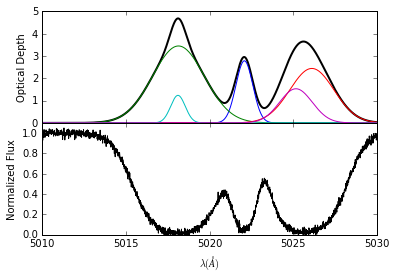

In [4]:
n = 5

clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True, saturated=True)

The plot shows the profile with added noise, but right now doesn't return this noisy profile, so we recreate it here.

In [5]:
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

To fit, initialise the model with `n` profiles, calculate the MAP estimate, then run the MCMC.

In [6]:
vpfit.initialise_model(wavelength_array, flux_array, n)

In [7]:
vpfit.map_estimate()

In [8]:
vpfit.mcmc_fit()

 [-----------------100%-----------------] 10000 of 10000 complete in 27.4 sec
Took: 0:00:27.372463  to finish.


Our `VPfit` instance, `vpfit`, now contains the fitted profile components.

We can query some features of the fit useful for model selection, such as the Maximum A Posteriori (MAP) Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC).

In [9]:
print vpfit.MAP.BIC
print vpfit.MAP.AIC

-9365.9758207
-9455.59026005


We also have model selection metrics from the MCMC

In [10]:
print vpfit.mcmc.BPIC
print vpfit.mcmc.DIC

-9888.7340177
-9893.15418429


In [11]:
vpfits.VPfit.Chisquared(vpfit.total.value, flux_array)

-55.762806438691719

In [12]:
vpfits.VPfit.ReducedChisquared(vpfit.total.value, flux_array, len(vpfit.estimated_variables))

-0.027951281422903117

Finally, we can also plot the fit, with residuals. The fitted components and actual components can be directly compared.

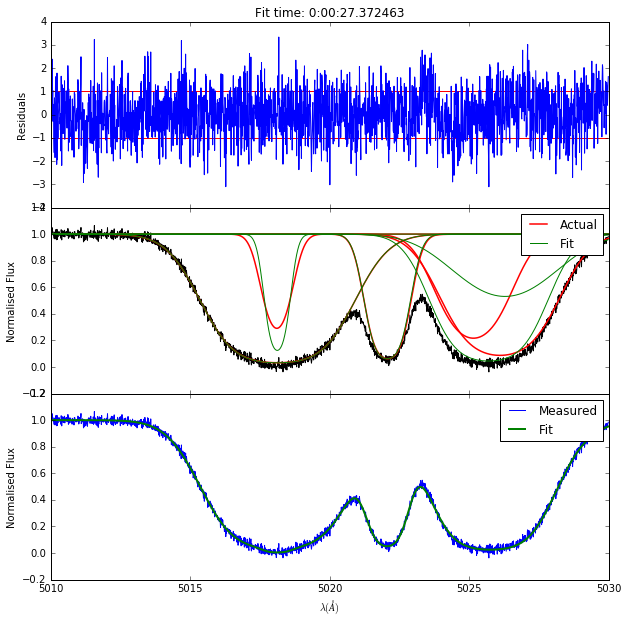

In [13]:
vpfit.plot(wavelength_array, flux_array, clouds, n=n)

## Finding the right number of profiles

In a complicated spectrum, knowing how many components there are can be difficult. `VPfits` can perform model selection on two fits with different numbers of profiles to determine which is the best.

Below is an early implementation using the Bayesian Information Criterion (BPIC) as a threshold.

In [20]:
r = 0
n = 1
vpfit_2 = vpfits.VPfit()
vpfit_2.initialise_model(wavelength_array, flux_array, n)
vpfit_2.map_estimate()

while r < 1:
    
    n += 1
    print "n: ", n
    
    vpfit_1 = vpfit_2
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.initialise_model(wavelength_array, flux_array, n)
    vpfit_2.map_estimate()
    
    print "Fit 1 BIC:", vpfit_1.MAP.BIC, "| Fit 2 BIC:", vpfit_2.MAP.BIC
    print "Fit 1 CSL", vpfits.VPfit.Chisquared(vpfit_1.total.value, flux_array), "| Fit 2 CS:", \
            vpfits.VPfit.Chisquared(vpfit_2.total.value, flux_array)
        
    print "BIC Ratio: ", vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    r = vpfit_1.MAP.BIC / vpfit_2.MAP.BIC
    
    
n -= 1
print "n (final): ", n
vpfit_1.mcmc_fit()

n:  2
Fit 1 BIC: -2000.89206849 | Fit 2 BIC: -3438.65236043
Fit 1 CSL 139.243959746 | Fit 2 CS: -496.468945633
BIC Ratio:  0.581882626902
n:  3
Fit 1 BIC: -3438.65236043 | Fit 2 BIC: -4855.88943205
Fit 1 CSL -496.468945633 | Fit 2 CS: 72.3472407608
BIC Ratio:  0.70814058033
n:  4
Fit 1 BIC: -4855.88943205 | Fit 2 BIC: -9473.87921817
Fit 1 CSL 72.3472407608 | Fit 2 CS: -113.462158068
BIC Ratio:  0.512555556201
n:  5
Fit 1 BIC: -9473.87921817 | Fit 2 BIC: -9768.48814978
Fit 1 CSL -113.462158068 | Fit 2 CS: -59.3398663464
BIC Ratio:  0.969840887649
n:  6
Fit 1 BIC: -9768.48814978 | Fit 2 BIC: -9774.61636838
Fit 1 CSL -59.3398663464 | Fit 2 CS: -56.1553792427
BIC Ratio:  0.99937304766
n:  7
Fit 1 BIC: -9774.61636838 | Fit 2 BIC: -9766.52088461
Fit 1 CSL -56.1553792427 | Fit 2 CS: -53.8607281744
BIC Ratio:  1.0008289015
n (final):  6
 [-----------------100%-----------------] 10000 of 10000 complete in 33.0 sec
Took: 0:00:33.030126  to finish.


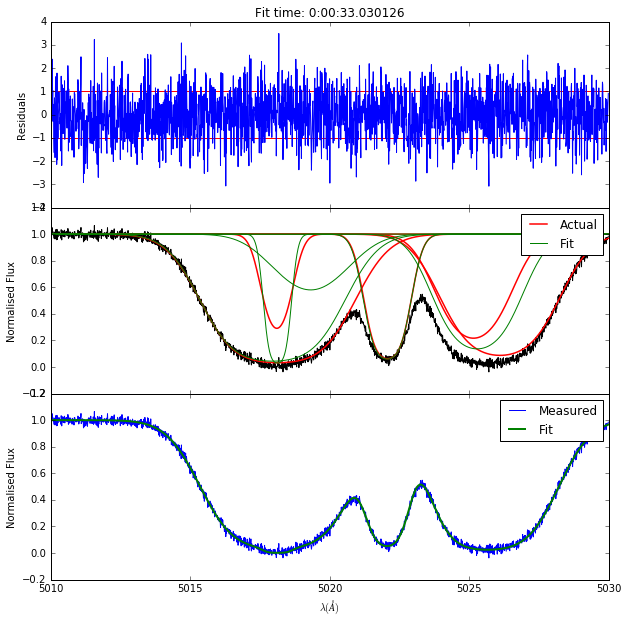

In [21]:
vpfit_1.plot(wavelength_array, flux_array, clouds, n-1)